# Basic Artificial Neural Networks

In [1]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib

%matplotlib inline

matplotlib.style.use('ggplot')

In [2]:
%run assignment1_modules.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            cur_old_grad = config['momentum'] * cur_old_grad + config['learning_rate'] * cur_dx
            
            if cur_old_grad.shape[0] == 1:
                cur_x = cur_x.reshape(cur_old_grad.shape)
            
            np.add(cur_x, -cur_old_grad, out=cur_x)
            i += 1     

In [4]:
# batch generator
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [5]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print(X_train.shape,y_train.shape)
X_train = (X_train.reshape(50000, 28*28))
X_test = (X_test.reshape(10000, 28*28))
# X_train
print(X_train.shape,y_train.shape)

(50000, 1, 28, 28) (50000,)
(50000, 784) (50000,)


One-hot encode the labels first.

In [6]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y_train= np.array(enc.fit_transform(y_train.reshape(-1, 1)).todense())
y_test = np.array(enc.fit_transform(y_test.reshape(-1, 1)).todense())
y_train.shape

(50000, 10)

In [7]:
def train(X_train, y_train, net, n_epoch, batch_size, criterion, optimizer_state, optimizer_config):
    loss_history = []
    for i in range(n_epoch):
        loss_h = []
        for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
            net.zeroGradParameters()
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_h.append(loss)
        loss_history.append(np.mean(loss_h))

        #  Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % loss) 
#     return loss_history


In [8]:
def accuracy_prediction(y_train, prediction):
    true = 0
    for index in range(len(prediction)):
        if np.argmax(y_train[index]) == np.argmax(prediction[index]):
            true +=1
    return true * 100/len(prediction)

def test(X_test, y_test, net, batch_size):
    accuracy = []
    for x_batch, y_batch in get_batches(X_test, y_test, batch_size):
        net.evaluate()
        net.zeroGradParameters()
        # Forward
        predictions = net.forward(x_batch)
        accuracy.append(accuracy_prediction(y_batch, predictions))
    return np.mean(accuracy)

# Autoencoder (optional) 

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
![](../imgs/autoencoder.png)

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use **MSECriterion** to score the reconstruction. Use **BatchMeanNormalization** between **Linear** and **ReLU**. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [9]:
optimizer_config = {'learning_rate' : 0.0001, 'momentum': 0.}

In [10]:
criterion = MSECriterion()


net = Sequential()
net.add(Linear(784, 512))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(512, 256))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(256, 128))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(128, 30))
net.add(Linear(30,128))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(128,256))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(256,512))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(512,784))
net.add(ReLU())

print(net)

Linear 784 -> 512
BatchMeanNormalization
ReLU
Linear 512 -> 256
BatchMeanNormalization
ReLU
Linear 256 -> 128
BatchMeanNormalization
ReLU
Linear 128 -> 30
Linear 30 -> 128
BatchMeanNormalization
ReLU
Linear 128 -> 256
BatchMeanNormalization
ReLU
Linear 256 -> 512
BatchMeanNormalization
ReLU
Linear 512 -> 784
ReLU



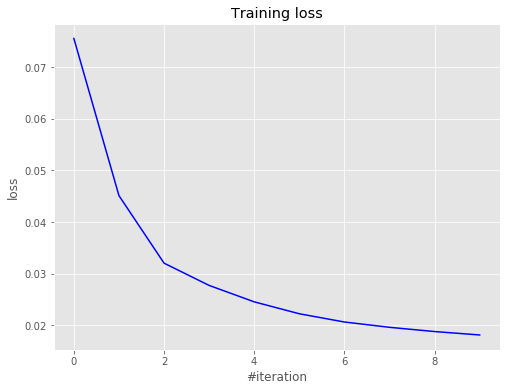

Current loss: 0.015342


In [11]:
train(X_train, X_train, net, 10, 50, criterion, {}, optimizer_config)

In [12]:
net.evaluate()
net.zeroGradParameters()
# Forward
predictions = net.forward(X_train[46])


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

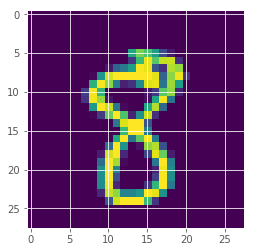

In [13]:
plt.imshow(X_train[46].reshape(28,28))
X_train

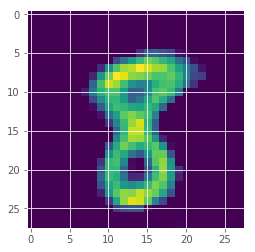

In [14]:
plt.imshow(predictions.reshape(28,28))

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [15]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
predictions = net.forward_auto(X_train, 9)
x_small = predictions

In [16]:
# Now build a logistic regression or small classification net
criterion = ClassNLLCriterion()


small_net = Sequential()
small_net.add(Linear(30, 20))
small_net.add(ReLU())
small_net.add(Linear(20, 10))
small_net.add(SoftMax())


print(small_net)

Linear 30 -> 20
ReLU
Linear 20 -> 10
SoftMax



In [17]:
# Learn the weights
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}

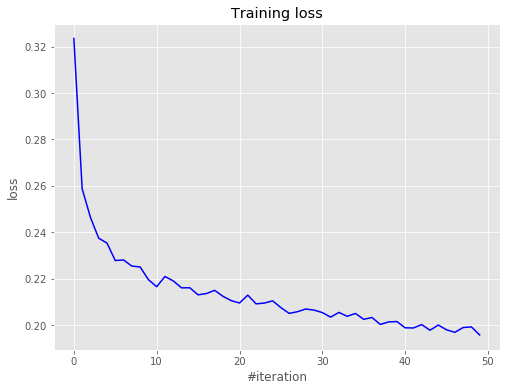

Current loss: 0.225356


In [18]:
train(x_small, y_train, small_net, 50, 50, criterion, {}, optimizer_config)

In [19]:
# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# And add learned layers ontop.

X_test_small = net.forward_auto(X_test, 9)
test(X_test_small, y_test, small_net, 50)

94.560000000000002

In [20]:
# lets compare svd with autoencoder

In [21]:
def compare(X_test, elem):
    #original     
    plt.imshow(X_test[elem].reshape(-1, 28))
    plt.show()
    #svd
    u,s,v = np.linalg.svd(X_test[elem].reshape(-1, 28))
    u1 = u[:,0:10]
    s1 = s[:10]
    v1 = v[:10]
    S1 = np.diag(s1)
    plt.imshow(np.dot(u1, np.dot(S1, v1)))
    plt.show()
    #autoencoder
    plt.imshow(net.forward(X_test[elem]).reshape(28,28))
    plt.show()

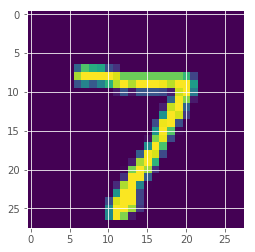

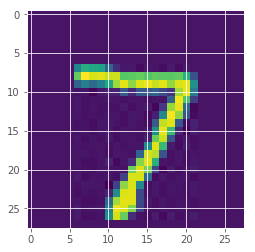

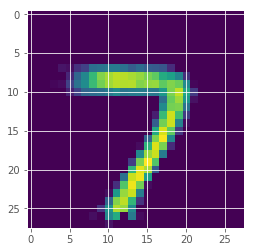

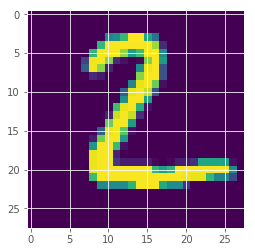

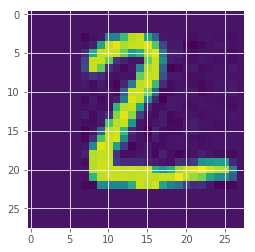

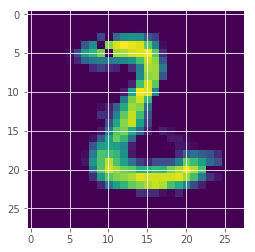

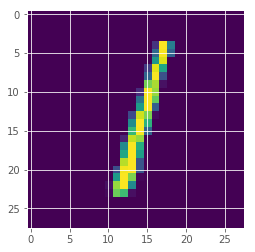

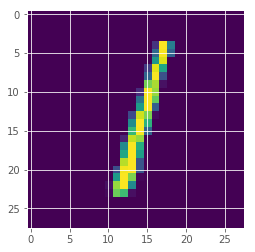

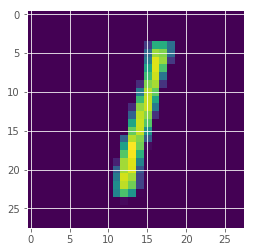

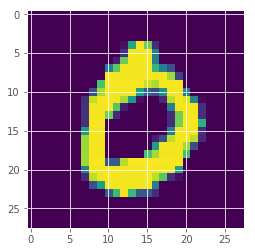

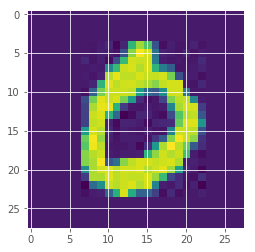

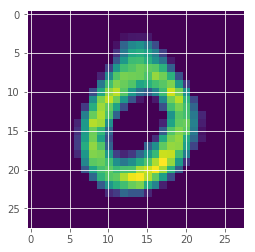

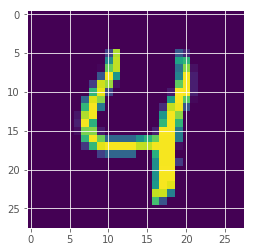

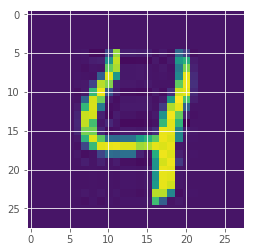

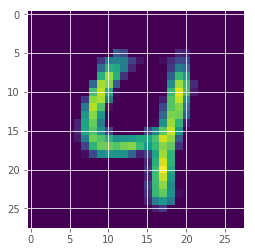

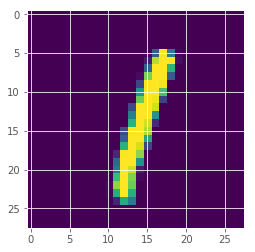

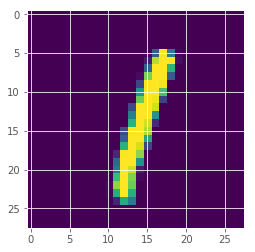

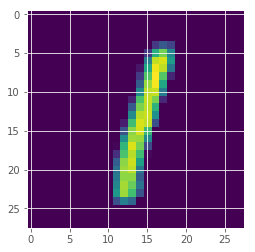

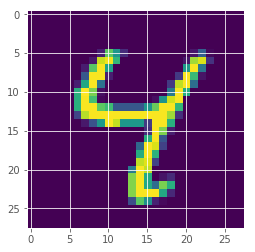

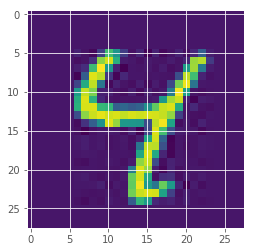

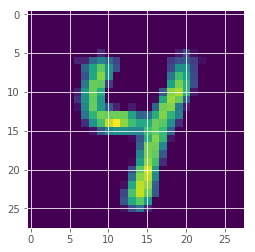

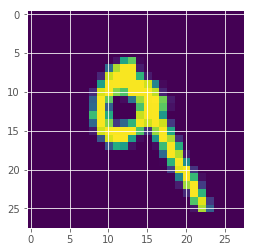

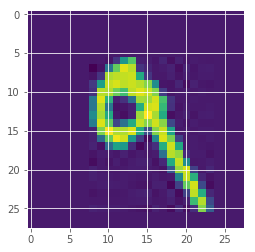

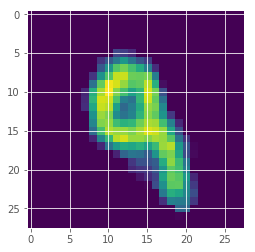

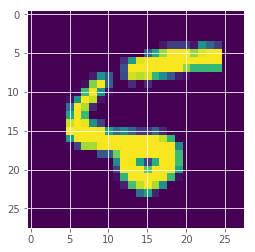

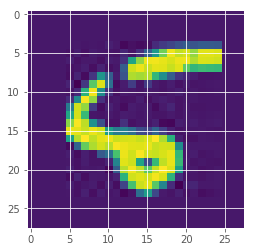

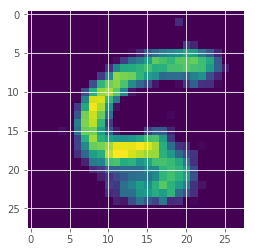

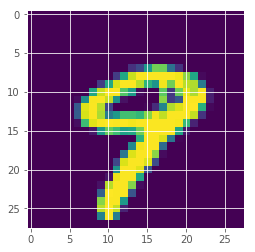

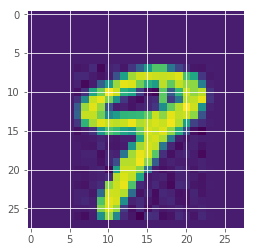

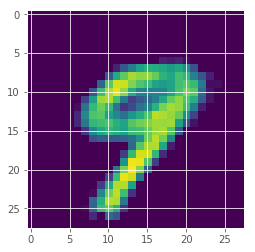

In [22]:
# prints original, with svd, and with autoencoder for given number
for elem in range(0,10):
    compare(X_test, elem)